<!-- ###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session -->

In [1]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
data_dir = '/kaggle/input/flower-classification'
train_dir = data_dir + '/train'

# Define your transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [ ]:
# Load a pre-trained network 
model = models.vgg16(pretrained=True)
model.name = "vgg16"
model

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 14, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model.to(device)

In [11]:
# Define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [16]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [ ]:
print(model)

In [14]:
print("Training process initializing .....\n")

for e in range(epochs):
    running_loss = 0
    model.train() # Technically not necessary, setting this for good measure
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
            running_loss = 0
            model.train()

print("\nTraining process is now complete!!")

Training process initializing .....

Epoch: 1/5 |  Training Loss: 4.1229 |  Validation Loss: 0.8877 |  Validation Accuracy: 0.7107
Epoch: 1/5 |  Training Loss: 0.9636 |  Validation Loss: 0.7040 |  Validation Accuracy: 0.7610
Epoch: 1/5 |  Training Loss: 0.8878 |  Validation Loss: 0.7182 |  Validation Accuracy: 0.7705
Epoch: 1/5 |  Training Loss: 0.8752 |  Validation Loss: 0.6433 |  Validation Accuracy: 0.7917
Epoch: 1/5 |  Training Loss: 0.8269 |  Validation Loss: 0.6917 |  Validation Accuracy: 0.7690
Epoch: 1/5 |  Training Loss: 0.7509 |  Validation Loss: 0.6281 |  Validation Accuracy: 0.7971
Epoch: 2/5 |  Training Loss: 0.5029 |  Validation Loss: 0.6032 |  Validation Accuracy: 0.8045
Epoch: 2/5 |  Training Loss: 0.7724 |  Validation Loss: 0.5538 |  Validation Accuracy: 0.8131
Epoch: 2/5 |  Training Loss: 0.7273 |  Validation Loss: 0.5811 |  Validation Accuracy: 0.8143
Epoch: 2/5 |  Training Loss: 0.7429 |  Validation Loss: 0.5886 |  Validation Accuracy: 0.8052
Epoch: 2/5 |  Training 

In [5]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [19]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  31.660800457000732
Accuracy achieved by the network on test images is: 82%


In [23]:

all_labels = np.array(labels_fp32)
all_predictions = np.array(predictions_fp32)
# Calculate the confusion matrix
cm = confusion_matrix(labels_fp32, predictions_fp32)
print("Confusion Matrix:")
print(cm)
print('----------------------------------------------------------------')
print("Classification Report:")
report = classification_report(all_labels, all_predictions)
print(report)

Confusion Matrix:
[[115   3   0   1   5   6   4   0   3   1   0   0   0   1]
 [  6 126   0   0  11   5   2   1   0  25   0   0   3   5]
 [  0   0 167   0   2   0   0  14   0   1   0   4   0   0]
 [  1   1   4 129  32   3   3  21   3   1   0   2   2   3]
 [  3   4   0   8 160   3   1   4   1   2   3   0   4   5]
 [  2   6   0   5   2 139   2   0   0   9  13   0   7   2]
 [  2  12   0   1  10   5 151   0   2   1   0   0   1   3]
 [  0   1  17  18  10   0   1 159   3   0   0   5   3   0]
 [  0   2   2   5   3   0   1   0 179   0   0   0   0   0]
 [  0   6   0   0   1   3   0   0   1 203   0   0   0   0]
 [  0   3   0   3   3  13   0   0   0   2 179   0   6   3]
 [  0   1  15   4   4   0   0   1   0   0   0 180   0   0]
 [  1   2   0   3   7   3   0   0   0   2   2   0 182   0]
 [  0   3   0   1   0   0   0   0   1   1   2   2   3 184]]
------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

     

In [25]:
original_dataset = train_data.dataset
# Create a class_to_idx mapping
model.class_to_idx = {class_name: idx for idx, class_name in enumerate(original_dataset.classes)}
checkpoint = {'architecture': model.name,
             'classifier': model.classifier,
             'class_to_idx': model.class_to_idx,
             'state_dict': model.state_dict()}

torch.save(checkpoint, 'model.pth')

In [18]:
def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load("/kaggle/input/models/model_vgg16.pth") # path to model
    
    # Download pretrained model
    model = models.vgg16(pretrained=True);
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

# QUANTIZATION

## FP-16

In [19]:
model_fp16 = load_checkpoint()

In [ ]:
model_fp16.half()
model_fp16.to(device)

In [ ]:
# weights_32 = model.state_dict()['features.0.weight']
# weights_16 = model_fp16.state_dict()['features.0.weight']
# weights_32_to_16 = torch.tensor(weights_32 ,dtype = torch.float16)
# weights_16 == weights_32_to_16

In [30]:
def pred_16(Model,Testloader):
    all_labels = []
    all_predictions = []

    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [26]:
labels_fp16,predictions_fp16 = pred_16(model_fp16,testloader)

Time:  17.344363927841187
Accuracy achieved by the network on test images is: 84%


## FP-64

In [ ]:
model_64 = load_checkpoint()
model_64.double()

In [32]:
model_64.to(device)
all_labels_fp64 = []
all_predictions_fp64 = []
correct_fp64 = 0
total_fp64 = 0
start_time_fp64 = time()
with torch.no_grad():
    model_64.eval()
    for images, labels in testloader:
        all_labels_fp64.extend(labels.numpy())
        images, labels = images.to(device), labels.to(device)
        outputs = model_64(images.double())
        _, predicted = torch.max(outputs.data, 1)
        total_fp64 += labels.size(0)
        correct_fp64 += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_fp64.extend(predicted_tensor_cpu.numpy())
end_time_fp64 = time()
print("Time: ",end_time_fp64 - start_time_fp64)

print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_fp64 / total_fp64))

Time:  736.1411633491516
Accuracy achieved by the network on test images is: 85%


## INT-8

In [37]:
from torch.ao.quantization import QuantStub, DeQuantStub
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx
import copy

In [38]:
model_fp32 = load_checkpoint()

In [ ]:
model_fp32.to('cpu')

In [40]:
input_data = next(iter(trainloader))[0][:1]  
calibrate_data = input_data.to("cpu")

In [ ]:
model_int8 = copy.deepcopy(model_fp32)
#model_int8.to(device)
qconfig_mapping = get_default_qconfig_mapping("qnnpack")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

In [42]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [ ]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

In [44]:
model_quantized_static

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04246700555086136, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0776933878660202, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.1062401533126831, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.18554028868675232, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.19455213844776154, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.22627805173397064, zero_point=0, padding=(1, 1))
    (14): Quantiz

In [ ]:
model_quantized_static.to('cpu')

In [49]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  329.43987917900085
Accuracy achieved by the network on test images is: 82%


In [50]:
model_quantized_static.state_dict().keys()

odict_keys(['features_0_input_scale_0', 'features_0_input_zero_point_0', 'features.0.weight', 'features.0.bias', 'features.0.scale', 'features.0.zero_point', 'features.2.weight', 'features.2.bias', 'features.2.scale', 'features.2.zero_point', 'features.5.weight', 'features.5.bias', 'features.5.scale', 'features.5.zero_point', 'features.7.weight', 'features.7.bias', 'features.7.scale', 'features.7.zero_point', 'features.10.weight', 'features.10.bias', 'features.10.scale', 'features.10.zero_point', 'features.12.weight', 'features.12.bias', 'features.12.scale', 'features.12.zero_point', 'features.14.weight', 'features.14.bias', 'features.14.scale', 'features.14.zero_point', 'features.17.weight', 'features.17.bias', 'features.17.scale', 'features.17.zero_point', 'features.19.weight', 'features.19.bias', 'features.19.scale', 'features.19.zero_point', 'features.21.weight', 'features.21.bias', 'features.21.scale', 'features.21.zero_point', 'features.24.weight', 'features.24.bias', 'features.2

In [58]:
weight_8 = model_quantized_static.state_dict()['features.0.weight']

## Extracting outputs and weights from fp32 model

In [20]:
model_fp32 = load_checkpoint()

In [ ]:
model_fp32

In [22]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
model_children = list(model_fp32.children())
print(model_children)

In [ ]:
model_children[0]

In [24]:
for i in range(len(model_children[0])):
    model_children[0][i].register_forward_hook(get_activation('conv'+str(i)))

In [25]:
model_fp32.to(device)
correct = 0
total = 0
count = 1
new = []
all_labels = []
all_predictions = []
with torch.no_grad():
    model_fp32.eval()
    for images, labels in testloader:
        new.extend(images)
        all_labels.extend(labels.numpy())
        images, labels = images.to(device), labels.to(device)
        outputs = model_fp32(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions.extend(predicted_tensor_cpu.numpy())
        if count == 1:
            break

print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))

Accuracy achieved by the network on test images is: 84%


In [ ]:
for i in range(len(activation)):
    print(i,':',activation['conv'+str(i)].shape)

In [27]:
activation.keys()

dict_keys(['conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13', 'conv14', 'conv15', 'conv16', 'conv17', 'conv18', 'conv19', 'conv20', 'conv21', 'conv22', 'conv23', 'conv24', 'conv25', 'conv26', 'conv27', 'conv28', 'conv29', 'conv30'])

In [21]:
model_fp32.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.fc1.weight', 'classifier.fc1.bias', 'classifier.fc2.weight', 'classifier.fc2.bias'])

### Extracting weights for testing 

In [30]:
# Extracting weights and bias to check only the shape and number of filters
weights_0 = model_fp32.state_dict()['features.0.weight']
bias_0 = model_fp32.state_dict()['features.0.bias']

In [31]:
weights_0.shape # --> torch.Size([64, 3, 3, 3]) ==> 64 filters of 3*3*3

torch.Size([64, 3, 3, 3])

In [23]:
weights_10.shape # --> torch.Size([256, 128, 3, 3]) 256 filters of 128*3*3

torch.Size([256, 128, 3, 3])

## CONV FUNCTION

In [32]:
def ReLU(z):
    return np.maximum(0, z)

In [33]:
def conv(image, input_shape, n_filters, filters, bias, kernel_size, stride, padding=False):
    if(padding):
        image = np.pad(image, ((0, 0), (1, 1),(1, 1)), mode='constant', constant_values=0)
    img_h, img_w = image.shape[1:]
    filter_h, filter_w = kernel_size[:]

    #filters = np.random.rand(n_filters, kernel_size[0], kernel_size[1], input_shape[2])

    output_fmaps = []
    fmap_h = (img_h - filter_h)//stride + 1
    fmap_w =  (img_w - filter_w)//stride + 1

    for n, filter in enumerate(filters[: , : , :, ]):
        fmap = np.zeros((fmap_h, fmap_w))

        sum = 0
        for i in range(0, stride*fmap_h, stride):
            for j in range(0, stride*fmap_w, stride):
                input_patch = image[:, i:i+filter_h, j:j+filter_w]
                sum = np.sum(input_patch * filter) + bias[n]
                fmap[i//stride, j//stride] = ReLU(sum)
        output_fmaps.append(fmap)

    return output_fmaps

## MAX POOLING 

In [ ]:
# import numpy as np

# def maxPool2D(fmaps, kernel_size, stride, padding=0):

#     # Add padding to the input image
#     padded_image = np.pad(image, pad_width=padding, mode='constant', constant_values=0)

#     # Initialize output image
#     output_image_maps = []
#     output_height = (padded_image.shape[0] - kernel_size) // stride + 1
#     output_width = (padded_image.shape[1] - kernel_size) // stride + 1
#     output_image = np.zeros((output_height, output_width))

#     # Perform max pooling
#     for i in range(0, padded_image.shape[0] - kernel_size + 1, stride):
#         for j in range(0, padded_image.shape[1] - kernel_size + 1, stride):
#             output_image[i // stride, j // stride] = np.max(padded_image[i:i + kernel_size, j:j + kernel_size])

#     return output_image


### Comparing Model outputs with custom conv function output

In [39]:
img_index = 3 # range from 0 to 49 -> 50 different images

In [ ]:
test_img = new[img_index].numpy()
io.imshow(test_img[0]) # test image has 3 channels,displaying only only 1 channel
io.show()

In [43]:
weights = model_fp32.state_dict()['features.0.weight']
bias = model_fp32.state_dict()['features.0.bias']
weights = weights.to('cpu').numpy()
bias = bias.to('cpu').numpy()

In [45]:
# Testing custom conv function for 1 image
start = time()
layer_1_fmaps = conv(test_img, test_img.shape, weights.shape[0], weights, bias, weights.shape[2:], stride=1,padding=True)
end = time()
print(f"Time taken : {end-start}")

Time taken : 43.804744243621826


In [47]:
layer_1_fmaps[0].dtype

dtype('float64')

In [49]:
layer_1_fmaps = [arr.astype(np.float32) for arr in layer_1_fmaps]

In [51]:
# getting the output of required layer for 50 images from model
layer1 = activation['conv0'].cpu().numpy() 

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


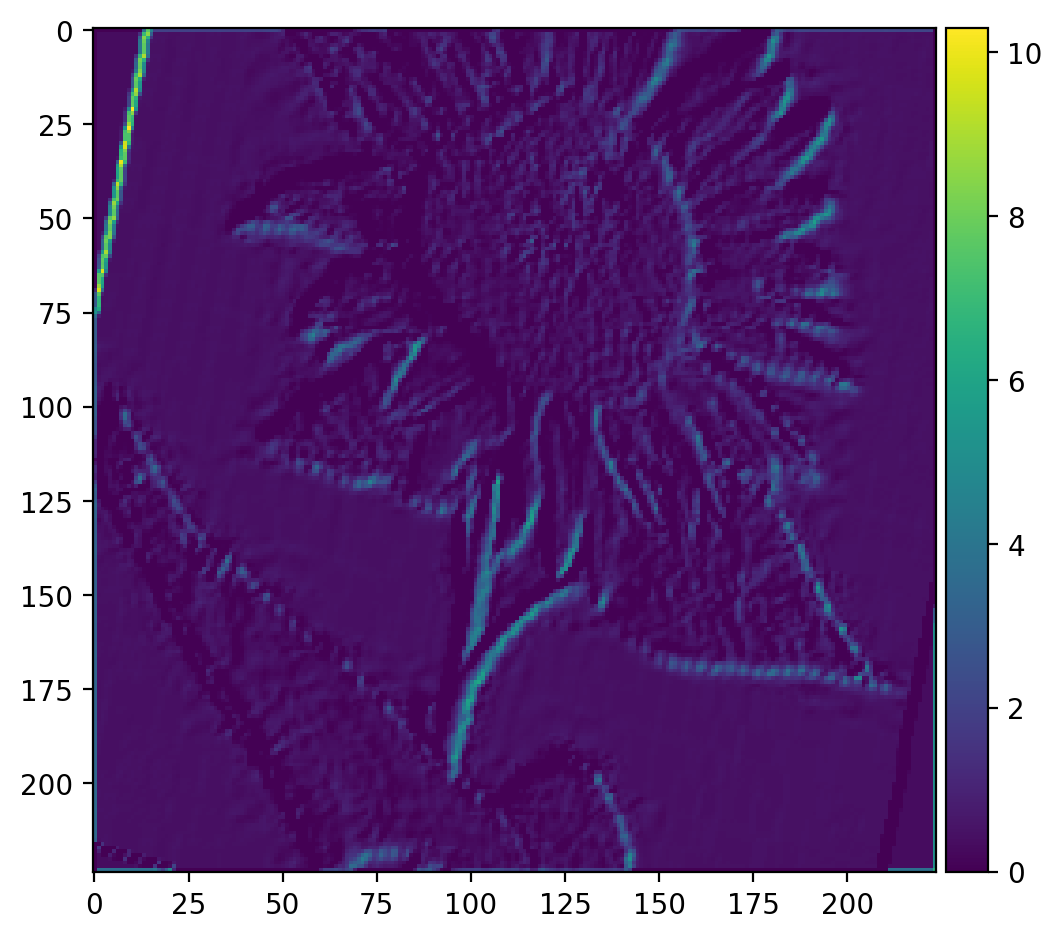

In [52]:
io.imshow(layer_1_fmaps[1]) # from custom function
io.show()

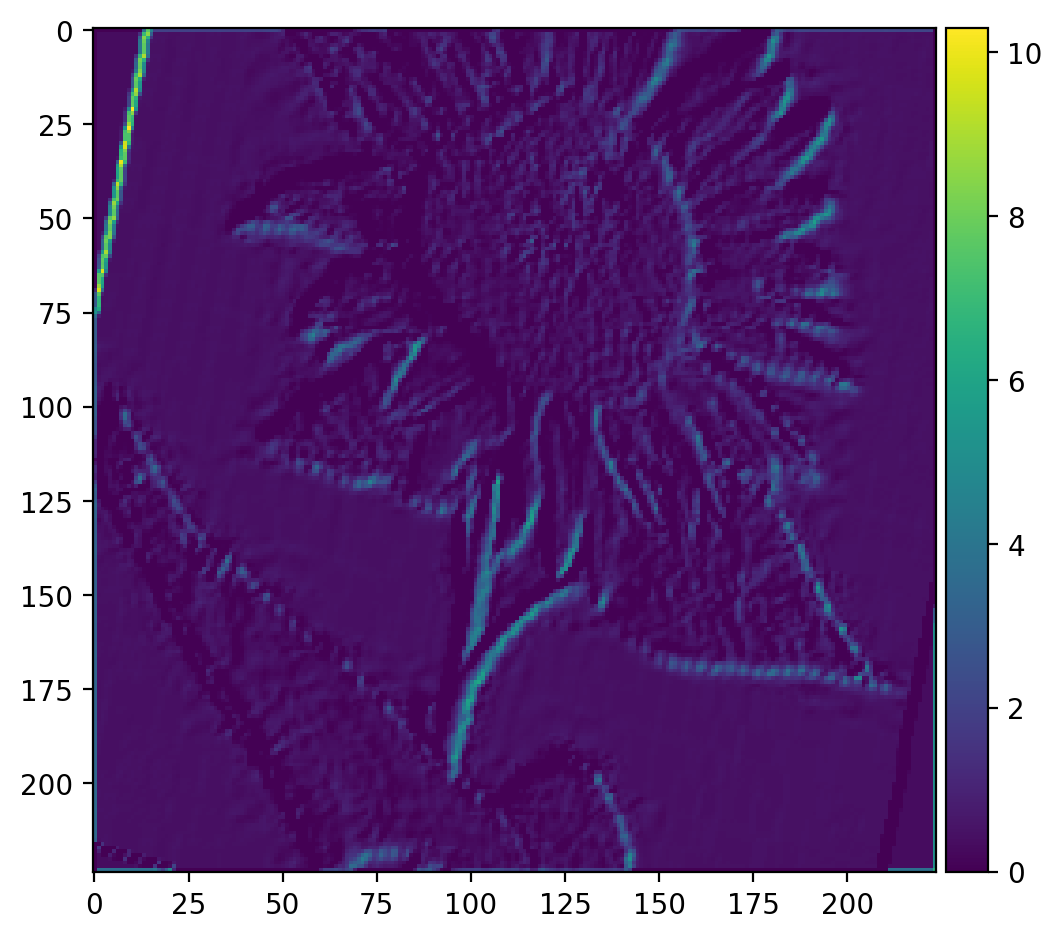

In [56]:
io.imshow(layer1[3][1] )
io.show()

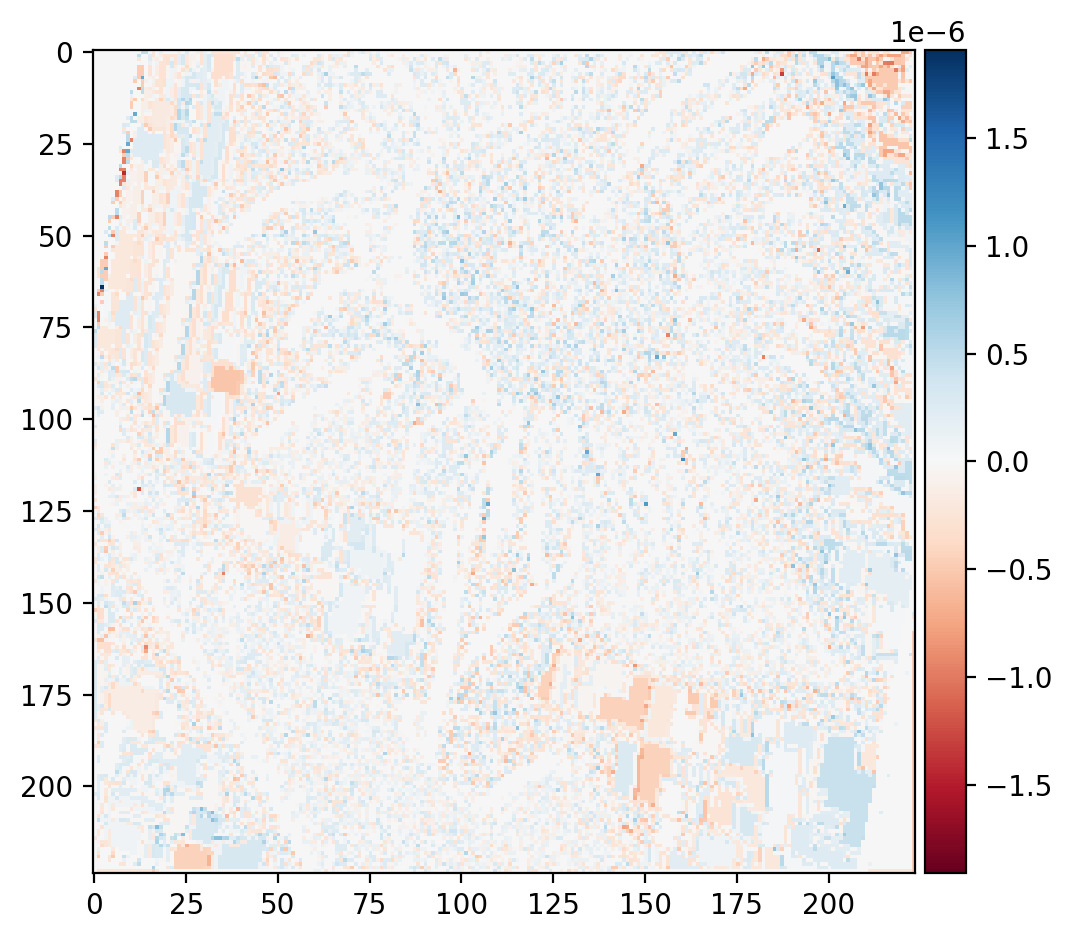

In [55]:
io.imshow(layer1[3][1] - layer_1_fmaps[1]) # difference in fp32
io.show()

In [58]:
layer1[3][1] # one ofmap out of 64 maps for an image out of 50 images

array([[0.        , 0.        , 0.        , ..., 2.117598  , 2.0983777 ,
        0.        ],
       [0.        , 0.33715394, 0.33715394, ..., 0.4320336 , 0.43731052,
        0.        ],
       [0.        , 0.33715394, 0.33715394, ..., 0.47116882, 0.4602552 ,
        0.        ],
       ...,
       [0.        , 0.33715394, 0.33715394, ..., 0.33715394, 0.33715394,
        5.075535  ],
       [0.        , 0.33715394, 0.33715394, ..., 0.33715394, 0.33715394,
        5.075535  ],
       [0.        , 3.8087075 , 3.8087075 , ..., 3.8087075 , 3.8087075 ,
        6.5665107 ]], dtype=float32)

In [59]:
layer_1_fmaps[1] # one ofmap out of 64 maps

array([[0.        , 0.        , 0.        , ..., 2.1175988 , 2.0983782 ,
        0.        ],
       [0.        , 0.33715394, 0.33715394, ..., 0.43203363, 0.43731079,
        0.        ],
       [0.        , 0.33715394, 0.33715394, ..., 0.47116908, 0.46025524,
        0.        ],
       ...,
       [0.        , 0.33715394, 0.33715394, ..., 0.33715394, 0.33715394,
        5.0755353 ],
       [0.        , 0.33715394, 0.33715394, ..., 0.33715394, 0.33715394,
        5.0755353 ],
       [0.        , 3.8087077 , 3.8087077 , ..., 3.8087077 , 3.8087077 ,
        6.566511  ]], dtype=float32)

In [ ]:
layer_1_fmaps[0].dtype == layer1[3][0].dtype

In [ ]:
layer_1_fmaps[0].shape == layer1[3][0].shape

In [61]:
layer_1_fmaps = [arr.astype(np.int8) for arr in layer_1_fmaps]
layer1[3] = [arr.astype(np.int8) for arr in layer1[3]]

In [64]:
layer_1_fmaps == layer1[3]

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

### Storing the weights in a pt file

In [38]:
weights = model_fp32.state_dict()['features.0.weight']

# Create a simple script module to hold the weights
class MyScriptModule(torch.jit.ScriptModule):
    def __init__(self, weights):
        super(MyScriptModule, self).__init__()
        self.weights = torch.nn.Parameter(weights)

    @torch.jit.script_method
    def forward(self):
        return self.weights

# Instantiate the script module and save it
script_module = MyScriptModule(weights)
script_module.save("features.0.weight.pt")